## This version includes a VFI and an EGM solver

Task: Optimize consumption over retirement and find optimal investment in a fairly priced annuity; investment only possible at time = 0 (age 65)

### Symbols
$c_t$: Consumption \
$w_t$: Wealth (beginning of period t) \
$a_t := w_t-c_t$: End of period wealth \
$p$: yearly payout of the annuity \
$R := 1+r$ with $r$ being the interest rate \
Wealth evolves according to $w_t = R * a_{t-1} + p$ \
$\sigma(w_t) = c_t^{*}$: Policy function


$u(c) := \frac{c^{1-\gamma}}{1-\gamma}$: Utility function (CRRA) \
$\gamma$ is the risk aversion parameter

Value function V:

$$V(w) := max \sum_{t=s}^{T} (\prod_{y=s}^{t}S(y)) \beta^t u(c_t)$$
Where $S(y)$ is the probability of surviving age $y$, $s$ is the starting age and $T$ is the final period

Euler equation:
$$u'(c_t) = S(t) \beta R u'(c_{t+1})$$

Solved for c_t:
$$c_t = (u')^{-1} [S(t) \beta R u'(\sigma(a_t + p))]$$

### Imports / Utility

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 9)  #set default figure size
plt.ion()
import numpy as np
from interpolation import interp
from scipy.optimize import minimize_scalar

In [2]:
# This is a temporary workaround; I copied the survival probabilities from https://www.ssa.gov/oact/STATS/table4c6.html
def get_s_prob(s, T):
    l = np.array([0.993919, 0.999575, 0.99974, 0.999806, 0.999846, 0.999858, 0.999865, 0.999873, 0.999884, 0.999896, 0.999903, 0.999894, 0.999856, 0.99978, 0.999677, 0.999563, 0.999448, 0.999325, 0.999194, 0.999061, 0.998921, 0.998785, 0.998673, 0.998594, 0.998539, 0.998493, 0.998443, 0.99839, 0.998332, 0.998268, 0.998205, 0.998142, 0.998077, 0.998008,
 0.997936, 0.997855, 0.997769, 0.997684, 0.997602, 0.997518, 0.99742, 0.997303, 0.997172, 0.997024, 0.996854, 0.99666, 0.996433, 0.996167, 0.995857, 0.995501,
 0.99511, 0.994679, 0.99419, 0.993637, 0.993027, 0.992371, 0.991678, 0.990951, 0.990194, 0.989405, 0.988548, 0.987642, 0.986745, 0.985874, 0.984994, 0.983999,
 0.982876, 0.981702, 0.980481, 0.979153, 0.977619, 0.975815, 0.973734, 0.97134, 0.968599, 0.965382, 0.961737, 0.95781, 0.953633, 0.949052, 0.943763,
 0.93764, 0.930774, 0.923116, 0.914548, 0.904938, 0.894171, 0.882162, 0.868862, 0.854249, 0.838322, 0.821095, 0.802592, 0.782851, 0.7619199999999999, 0.741179,
 0.721034, 0.701908, 0.684238, 0.66845, 0.651872, 0.634466, 0.616189, 0.5969990000000001, 0.576849, 0.5556909999999999, 0.5334760000000001, 0.510149,
 0.485657, 0.45994, 0.432937, 0.404583, 0.37481299999999995, 0.343553, 0.310731, 0.27626799999999996,
 0.240081, 0.20208499999999996, 0.16218900000000003, 0.12029900000000004])
    return l[s:T]

def get_annuity_payment(annuity_investment, S, R):
    accumulated_p_surv = 1
    res = 0
    for t in range(len(S)):
        accumulated_p_surv *= S[t]
        res += accumulated_p_surv / R ** t
    return annuity_investment / res

### Define Model

In [3]:
class Model:
    def __init__(self,
                 endowment=100,
                 beta=0.96,
                 gamma=5,
                 s=65,
                 T=100,
                 r=0.02,
                 annuity_investment=0,
                 annuity_pricing_factor=1,
                 consider_survival_prob=True,  # If set to false, S(t)=1 for all t
                 grid_min=1e-10,
                 grid_max=100,
                 grid_size=101
                ):
        assert endowment >= annuity_investment, "Endowment needs to be >= annuity_investment"
        self.endowment, self.beta, self.gamma, self.s, self.T = endowment, beta, gamma, s, T
        self.annuity_investment = annuity_investment
        self.n = T-s
        self.R = 1 + r
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        if consider_survival_prob:
            self.S = get_s_prob(s, T)
        else:
            self.S = np.full(self.n, 1)
        self.annuity_pricing_factor = annuity_pricing_factor
        self.p = get_annuity_payment(annuity_investment, self.S, self.R) / annuity_pricing_factor

    def __repr__(self):
        return f"Model with parameters: endowment={self.endowment}, annuity investment={self.annuity_investment}, annuity pricing factor={self.annuity_pricing_factor}, beta={self.beta}, gamma={self.gamma}, s={self.s}, T={self.T}, r={self.R}, p={self.p}"

    # Utility function
    def u(self, c):
        return c ** (1-self.gamma) / (1 - self.gamma)
    # Marginal utility
    def u_prime(self, c):
        return c ** -self.gamma
    # Inverse marginal utility
    def u_prime_inv(self, c):
        return c ** (-1 / self.gamma)

### Solve Model
#### Using EGM

In [4]:
def solve_egm(model):
    sigma = np.empty([model.n, len(model.grid)])
    sigma[-1] = model.grid # Consume everything

    # Backward induction
    for t in reversed(range(model.n - 1)):
        w_temp = np.empty(len(model.grid))
        sigma_temp = np.empty(len(model.grid))
        sigma_next = lambda w: interp(model.grid, sigma[t+1], w)

        for i, a in enumerate(model.grid):
            w_next = model.R * a + model.p
            sigma_temp[i] = model.u_prime_inv(model.S[t] * model.beta * model.R * model.u_prime(sigma_next(w_next)))
            w_temp[i] = sigma_temp[i] + a

        # Interpolate results back to common grid
        for i, w in enumerate(model.grid):
            # Set upper limit of c <= w
            sigma[t, i] = min(interp(w_temp, sigma_temp, w), w)
    return sigma

#### Using VFI

In [5]:
# utility, copied from quantecon; maximizes f within bounds of a and b
def maximize(f, a, b, args):
    objective = lambda x: -f(x, *args)
    res = minimize_scalar(objective, bounds=(a,b), method="bounded")
    maximizer, maximum = res.x, -res.fun
    return maximizer, maximum

# Optimize over c
def obj_bellman(c, t, w, v_grid, model):
    a = w-c
    a = max(a, model.grid[0])  # Fix this; How to deal with the case w=c -> a=0? Outside of grid
    v_n = interp(model.grid, v_grid[t+1], a * model.R + model.p)  # Value function for next period
    return model.u(c) + model.beta * model.S[t] * v_n

def solve_vfi(model):
    sigma_grid = np.empty((model.n, len(model.grid)))
    v_grid = np.empty((model.n, len(model.grid))) # Used to store expected values

    # Last period
    sigma_grid[-1] = np.copy(model.grid) * 1.0
    v_grid[-1] = model.u(sigma_grid[-1])

    for t in reversed(range(model.n - 1)):
        for i, w in enumerate(model.grid):
            sigma_grid[t, i], v_grid[t,i] = maximize(obj_bellman, 0, w, args=(t, w, v_grid, model))

    return sigma_grid

###  Simulate Lifecycle

In [6]:
def simulate_lifecycle(sigma_grid, m):
    a_grid = np.empty(m.n)
    w_grid = np.empty(m.n)
    c_grid = np.empty(m.n)
    # Expected Value
    v = 0

    surv_prob_accumulated = 1

    for t in range(m.n):
        sigma = lambda w: interp(m.grid, sigma_grid[t], w)
        if t == 0:
            w_grid[0] = m.endowment - m.annuity_investment + m.p
            c_grid[0] = sigma(w_grid[0])
            a_grid[0] = w_grid[0] - c_grid[0]
            v = m.u(c_grid[0])
        else:
            w_grid[t] = m.R * a_grid[t-1] + m.p
            c_grid[t] = sigma(w_grid[t])
            a_grid[t] = w_grid[t] - c_grid[t]
            v += m.beta ** t * surv_prob_accumulated * m.u(c_grid[t])
        surv_prob_accumulated *= m.S[t]

    return w_grid, c_grid, v

### Functions for Plotting and Comparing Results

In [7]:
def plot_policy_function(ax, sigma, model, model_identifier=""):
    ax.set_title(f"Policy function {model_identifier}")
    ax.set_xlabel("wealth")
    ax.set_ylabel("consumption")
    for i in range(len(sigma)):
        # Plot a label for every 5th period
        if i % 5 == 0 or i == len(sigma) - 1:
            ax.plot(model.grid, sigma[i], color=plt.cm.jet(i / len(sigma)), lw=2, alpha=0.6, label=f"t={i}")
        else:
            ax.plot(model.grid, sigma[i], color=plt.cm.jet(i / len(sigma)), lw=2, alpha=0.6)
    ax.legend()

def plot_lifecycle(m, ax, ax_cons, w_grid, c_grid, color_w, color_c, model_identifier=""):
    ax.set_title(f"Simulated consumption / wealth development")
    ax.set_xlabel("Time")
    ax.set_ylabel("wealth / consumption")
    ax.plot(range(m.n), w_grid, color=color_w, lw=2, alpha=0.6, label=f"wealth {model_identifier}")
    ax.plot(range(m.n), c_grid, color=color_c, lw=2, alpha=0.6, label=f"consumption {model_identifier}")
    ax.legend()

    ax_cons.set_title(f"Simulated consumption")
    ax_cons.set_xlabel("Time")
    ax_cons.set_ylabel("consumption")
    ax_cons.plot(range(m.n), c_grid, color=color_c, lw=2, alpha=0.6, label=f"consumption {model_identifier}")
    ax_cons.legend()

# Used for comparing results between VFI and EGM solver
def plot_vfi_egm_comp(model, sigma_vfi, sigma_egm, w_grid_vfi, w_grid_egm, c_grid_vfi, c_grid_egm):
    fig, ((ax_sig_vfi,ax_sig_egm),(ax_wealth,ax_cons)) = plt.subplots(2,2)
    plot_policy_function(ax_sig_vfi, sigma_vfi, model, "VFI")
    plot_policy_function(ax_sig_egm, sigma_egm, model, "EGM")
    plot_lifecycle(model, ax_wealth, ax_cons, w_grid_vfi, c_grid_vfi, "red", "blue", "VFI")
    plot_lifecycle(model, ax_wealth, ax_cons, w_grid_egm, c_grid_egm, "olive", "green", "EGM")

def solve_and_plot_vfi_egm_comp(m):
    print(m)
    sigma_vfi = solve_vfi(m)
    sigma_egm = solve_egm(m)
    w_grid_vfi, c_grid_vfi, v_vfi = simulate_lifecycle(sigma_vfi, m)
    w_grid_egm, c_grid_egm, v_egm = simulate_lifecycle(sigma_egm, m)
    plot_vfi_egm_comp(m, sigma_vfi, sigma_egm, w_grid_vfi, w_grid_egm, c_grid_vfi, c_grid_egm)

# Used for comparing results with different model parameters
def plot_model_comp(m1, m2, sigma_1, sigma_2, w_grid_1, w_grid_2, c_grid_1, c_grid_2, identifier1, identifier2):
    fig, ((ax_sig_1,ax_sig_2),(ax_wealth,ax_cons)) = plt.subplots(2,2)
    plot_policy_function(ax_sig_1, sigma_1, m1, identifier1)
    plot_policy_function(ax_sig_2, sigma_2, m2, identifier2)
    plot_lifecycle(m1, ax_wealth, ax_cons, w_grid_1, c_grid_1, "red", "blue", identifier1)
    plot_lifecycle(m2, ax_wealth, ax_cons, w_grid_2, c_grid_2, "olive", "green", identifier2)

def solve_and_plot_comp(m1, m2, identifier1, identifier2):
    print(f"Model 1: {m1}")
    print(f"Model 2: {m2}")
    sigma_1 = solve_egm(m1)
    sigma_2 = solve_egm(m2)
    w_grid_1, c_grid_1, v_1 = simulate_lifecycle(sigma_1, m1)
    w_grid_2, c_grid_2, v_2 = simulate_lifecycle(sigma_2, m2)
    plot_model_comp(m1, m2, sigma_1, sigma_2, w_grid_1, w_grid_2, c_grid_1, c_grid_2, identifier1, identifier2)

### Sensitivity Analysis

Model 1: Model with parameters: endowment=100, annuity investment=0, annuity pricing factor=1, beta=0.96, gamma=2, s=65, T=100, r=1.02, p=0.0
Model 2: Model with parameters: endowment=100, annuity investment=0, annuity pricing factor=1, beta=0.96, gamma=9, s=65, T=100, r=1.02, p=0.0


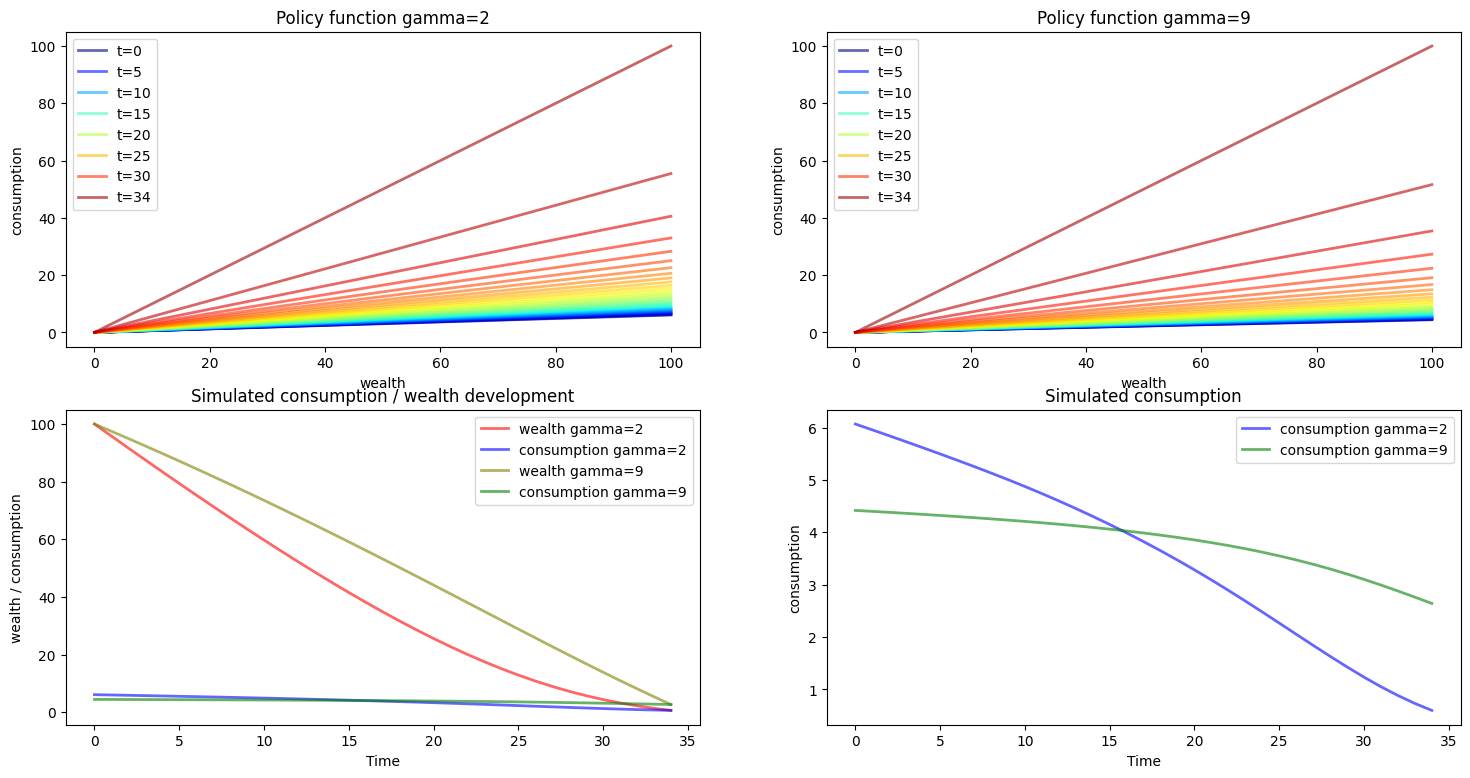

In [8]:
m1 = Model(gamma=2)
m2 = Model(gamma=9)
solve_and_plot_comp(m1, m2, "gamma=2", "gamma=9")

Model 1: Model with parameters: endowment=100, annuity investment=0, annuity pricing factor=1, beta=0.9, gamma=5, s=65, T=100, r=1.02, p=0.0
Model 2: Model with parameters: endowment=100, annuity investment=0, annuity pricing factor=1, beta=0.999, gamma=5, s=65, T=100, r=1.02, p=0.0


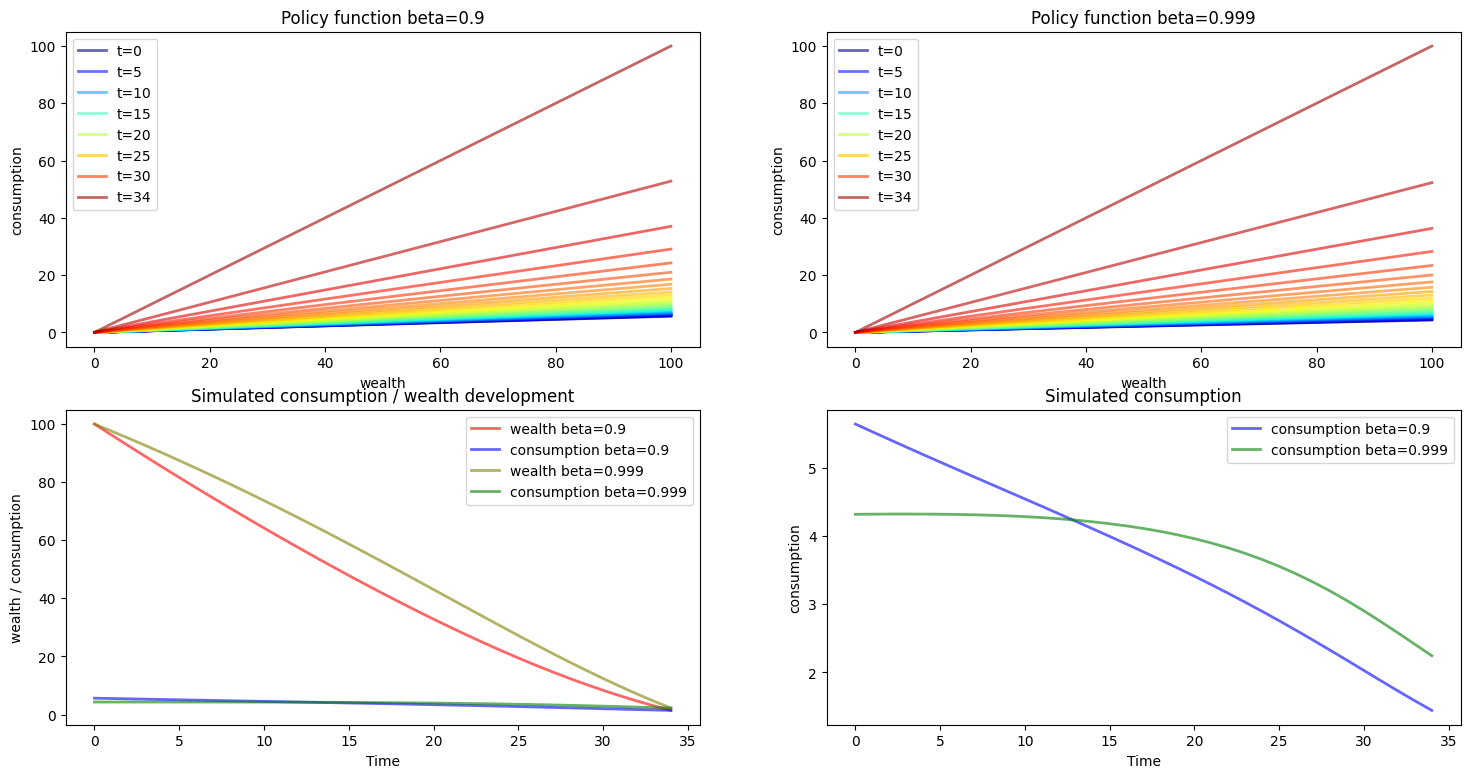

In [9]:
m1 = Model(beta=0.9)
m2 = Model(beta=0.999)
solve_and_plot_comp(m1, m2, "beta=0.9", "beta=0.999")

Model 1: Model with parameters: endowment=100, annuity investment=100, annuity pricing factor=1.2, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=5.766888382865693
Model 2: Model with parameters: endowment=100, annuity investment=100, annuity pricing factor=1.5, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=4.613510706292554


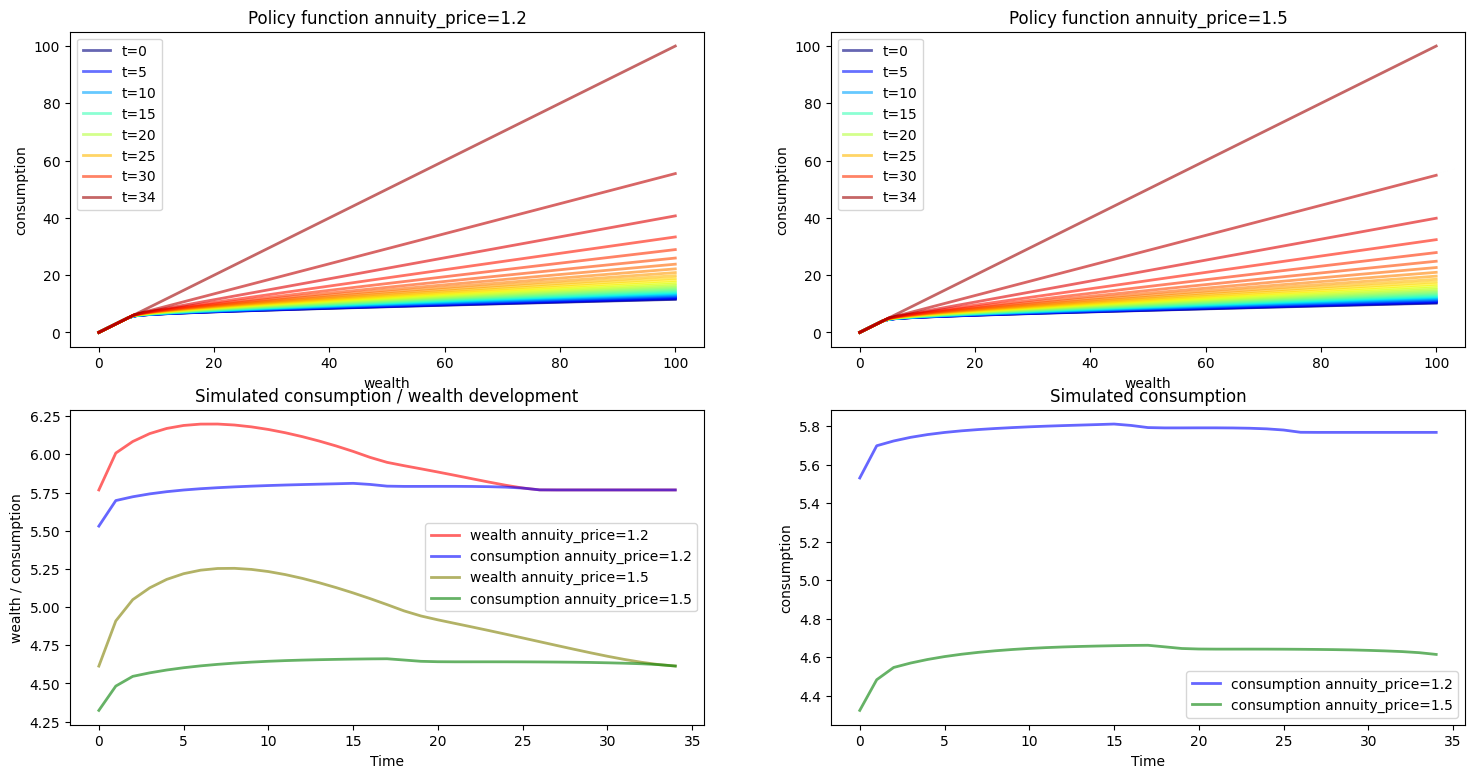

In [10]:
m1 = Model(annuity_investment=100, annuity_pricing_factor=1.2)
m2 = Model(annuity_investment=100, annuity_pricing_factor=1.5)
solve_and_plot_comp(m1, m2, "annuity_price=1.2", "annuity_price=1.5")

### VFI / EGM comparison: annuity investment = 0

Model with parameters: endowment=100, annuity investment=0, annuity pricing factor=1, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=0.0


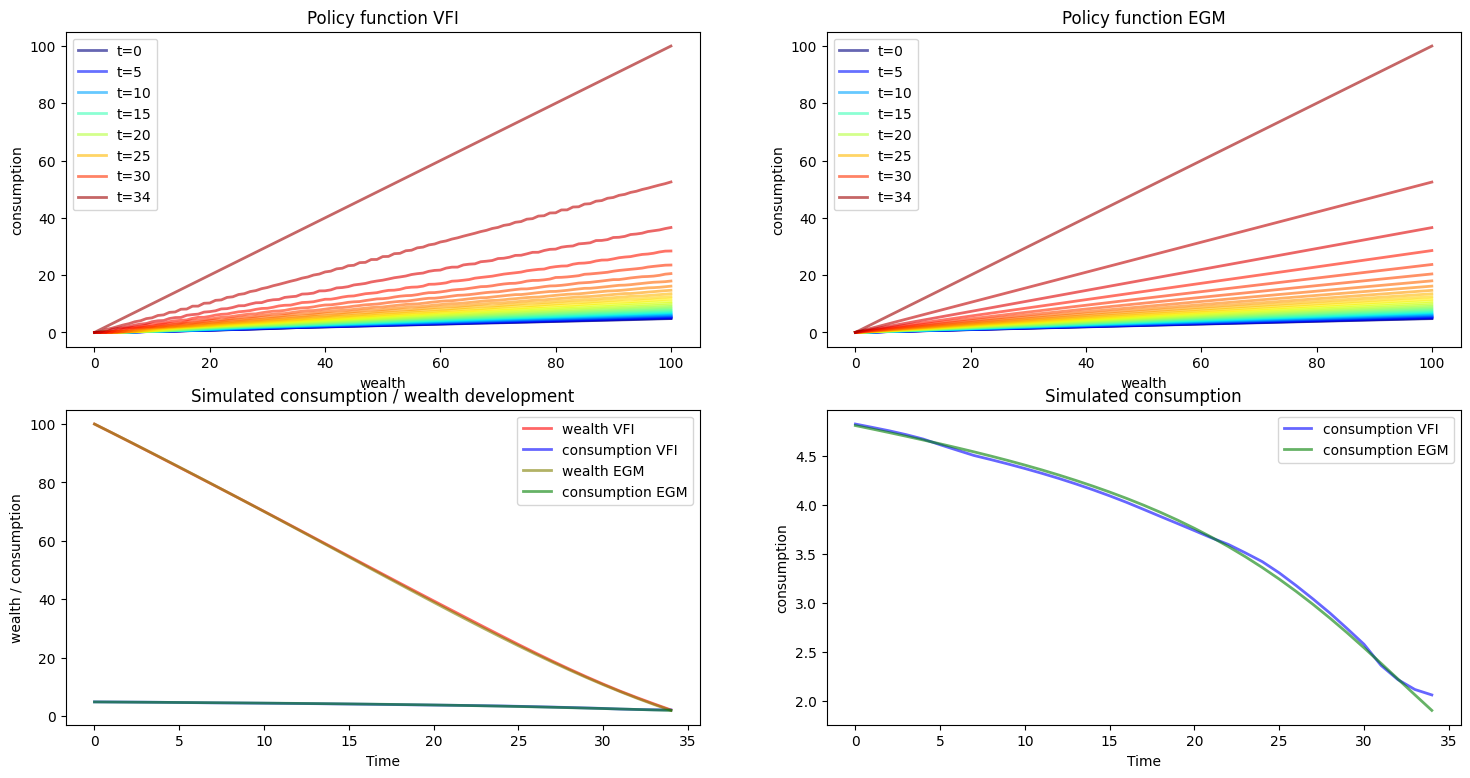

In [11]:
m = Model()
solve_and_plot_vfi_egm_comp(m)

### VFI / EGM comparison: annuity investment = 100

Model with parameters: endowment=100, annuity investment=100, annuity pricing factor=1, beta=0.96, gamma=5, s=65, T=100, r=1.02, p=6.920266059438831


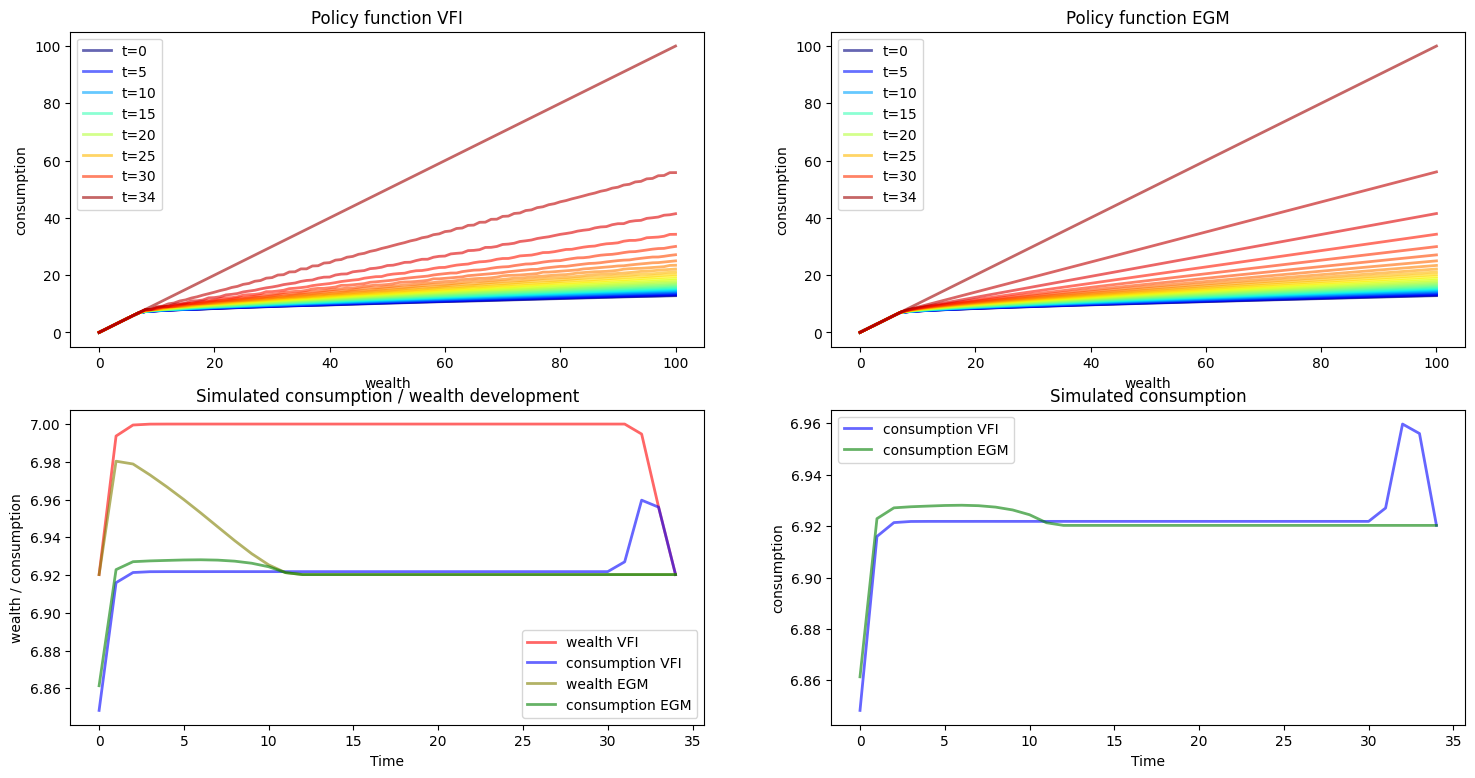

In [12]:
m = Model(annuity_investment=100)
solve_and_plot_vfi_egm_comp(m)

### Find optimal annuity investment

In [13]:
# This function is best called with a grid size so that 100 % (grid_size-1) = 0; e.g. 11, 21, 51, 101
# Currently this function will only find the optimal annuity investment if it is exactly on the grid;
# Once necessary I can consider interpolating inbetween the grid values
def find_optimal_annuity(model_solver, grid_size):
    step_size = 100 / (grid_size-1)
    expected_values = np.empty(grid_size)
    for i in range(grid_size):
        m = Model(annuity_investment=i*step_size)
        sigma = model_solver(m)
        expected_values[i] = simulate_lifecycle(sigma, m)[2]
    return np.argmax(expected_values) * step_size, expected_values[-1]

In [14]:
optimal_investment_vfi, value_vfi = find_optimal_annuity(solve_vfi, 21)
print(f"Optimal annuity investment using VFI is {optimal_investment_vfi} and with an expected value of {value_vfi}")
optimal_investment_egm, value_egm = find_optimal_annuity(solve_egm, 21)
print(f"Optimal annuity investment using EGM is {optimal_investment_egm} and with an expected value of {value_egm}")

Optimal annuity investment using VFI is 100.0 and with an expected value of -0.00136899271365809
Optimal annuity investment using EGM is 100.0 and with an expected value of -0.0013659619474459062
